### Compute equilibrium and stationary distribution using generalized code

Proof of concept for computing equilibrium and the stationary distribution using generalized code that can take a model with:
- Arbitrary number of Markov states
- Arbitrary number of control varaibles
- Arbitrary number of endogenous state variables

Main technical problem is constructing the transition matrices (Q) for more than one exogeneous and endogenous variable.

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa
import matplotlib.pyplot as plt
from dolo.algos.dtmscc.time_iteration import time_iteration
import dolo.algos.dtmscc.distributions_general as dst
from dolo import yaml_import, pcat
from operator import mul
from functools import reduce


In [2]:
filename = 'incomplete_markets_dtmscc.yaml'
model = yaml_import(filename)

Nf = np.array([100])


In [3]:
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr')

### Next: construct fine grid for arbitrary number of state variables

In [4]:
sgridf = dst.fine_grid(model, Nf)
sgridf.shape

(100, 1)

In [67]:
# model2 = yaml_import('rbc_full.yaml')
# Nf = np.array([100, 500])
# sgridf = dst.fine_grid(model2, Nf)
# gridf

### Next: produce the next period's state variable from the markov decision rule

In [5]:
sprimef = dst.mdr_to_sprime(model, mdr, Nf)

### Next: compute the stationary distribution for the model. 


In [6]:
L, QT = dst.stat_dist(model, mdr, Nf=Nf, verbose=True)

Iteration = 0, dist = 0.372600 

Iteration = 100, dist = 0.006785 

Iteration = 200, dist = 0.003737 

Iteration = 300, dist = 0.001271 

Iteration = 400, dist = 0.000285 

Iteration = 500, dist = 0.000053 

Iteration = 600, dist = 0.000009 

Iteration = 700, dist = 0.000002 

Iteration = 800, dist = 0.000000 

Iteration = 900, dist = 0.000000 



### Compute the equilibrium of the model

To generalize this step:
- Pick an initial value for the aggregate state variable(s) that enters the individual agent's decision rule.
- Compute the stationary distribution of the model
- Using the stationary distribution, compute the observed aggregate variable(s).
- Using a damping method to pick a new guess for the aggregate state variable, and then repeat.

##### Problems
- With more than one aggregate state variable, need multiple dampings. How do we set up these loops in a general way? 

### Compute the equilibrium interest rate 

In [ ]:
K = dst.solve_eqm(model, Kinit=38, tolKeq=1e-5, verbose=True)

### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [ ]:
# Set model calibration to the equilibrium aggregate capital stock.
model.set_calibration(kagg=K)

# drc = time_iteration(model, with_complementarities=True, verbose=False, output_type='controls') 
mdr = time_iteration(model, with_complementarities=True, verbose=False, output_type='dr') 

In [ ]:
L, QT = dst.stat_dist(model, mdr, Nkf=Nkf, verbose=True)

### Plot the equilibrium stationary distribution and decision rules

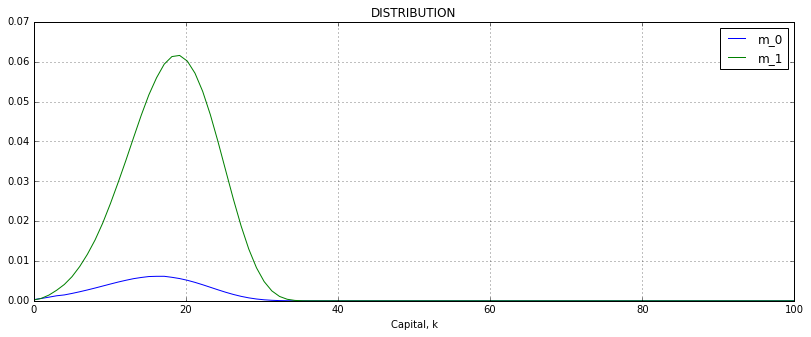

In [48]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(sgridf[0], L[:Nf[0]],label='m_0')
plt.plot(sgridf[0], L[Nf[0]:],label='m_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

In [ ]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

In [ ]:
# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 